In [ ]:
#Twitter Sentiment Analysis

In [ ]:
pip install python-docx

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 239.6/239.6 kB 4.0 MB/s eta 0:00:00


In [ ]:
#Loading the libraries
import googleapiclient.discovery
import googleapiclient.errors
from textblob import TextBlob
from wordcloud import WordCloud
import pandas as pd
import numpy as np
import re
import sys
import matplotlib.pyplot as plt
import random
import os
plt.style.use('fivethirtyeight')

from docx import Document
from docx.shared import Inches
from wordcloud import WordCloud, STOPWORDS
from PIL import Image
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from nltk.stem import SnowballStemmer
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from sklearn.feature_extraction.text import CountVectorizer

In [ ]:

api_service_name = "youtube"
api_version = "v3"
DEVELOPER_KEY = "Developer Key"  #Enter Developer Key

youtube = googleapiclient.discovery.build(
    api_service_name, api_version, developerKey=DEVELOPER_KEY)

search_query = input("Enter Youtuber :")

channel_request = youtube.channels().list(
    part = "statistics",
    id = search_query
)
channel_response = channel_request.execute()

if "items" in channel_response:
    subscriber_count = channel_response["items"][0]["statistics"]["subscriberCount"]
    print(f"Subscriber Count: {subscriber_count}")
else:
    print("Subscriber count not found")

#search_query = "beerbiceps"  # Replace with your desired search keywords
comment_texts = []

# Fetch search results
search_request = youtube.search().list(
    q = search_query,
    type = "video",
    part = "id",
    maxResults=50  # Adjust the number of search results as needed
)

search_response = search_request.execute()

# Pick a random video from the search results
if "items" in search_response:
    random_video = random.choice(search_response["items"])
    video_id = random_video["id"]["videoId"]

comment_request = youtube.commentThreads().list(
    part = "snippet",
    videoId = video_id,
    maxResults = 200
)
comment_response = comment_request.execute()

for item in comment_response['items']:
    comment_text = item['snippet']['topLevelComment']['snippet']['textDisplay']
    comment_texts.append(comment_text)

comments_df = pd.DataFrame(comment_texts, columns=["Comment Text"])
print(comments_df)



Enter Youtuber :Flying Beast
Subscriber count not found
                                         Comment Text
0   Pihu is a Gangster the last bencher and RIHU i...
1                 Pihu is very cute ❤ God bless her ❤
2   Main cause of double ptaka is rashi.... Rashi ...
3   Ye sab ajkal vlogs Kam cartoon jyada lag rahe ...
4   in this time <a href="https://www.youtube.com/...
..                                                ...
95  Fun fact:<br>Rashi&#39;s real name is kaira❤ <...
96  The air India flight which got bombed was Kani...
97                            Nice vlog gaurav bhaiya
98                                 Rashi is so wise❤❤
99  Rashi na bholi hai or pihu shetan hai dono piy...

[100 rows x 1 columns]


In [ ]:
#sentiment analysis
def analyze_sentiment(text):
    analysis = TextBlob(text)
    # Classify sentiment as positive, negative, or neutral
    if analysis.sentiment.polarity > 0:
        return "Positive"
    elif analysis.sentiment.polarity < 0:
        return "Negative"
    else:
        return "Neutral"

comments_df["Sentiment"] = comments_df["Comment Text"].apply(analyze_sentiment)
print(comments_df)
#print(search_response)

                                         Comment Text Sentiment
0   Pihu is a Gangster the last bencher and RIHU i...  Positive
1                 Pihu is very cute ❤ God bless her ❤  Positive
2   Main cause of double ptaka is rashi.... Rashi ...  Positive
3   Ye sab ajkal vlogs Kam cartoon jyada lag rahe ...   Neutral
4   in this time <a href="https://www.youtube.com/...  Negative
..                                                ...       ...
95  Fun fact:<br>Rashi&#39;s real name is kaira❤ <...  Positive
96  The air India flight which got bombed was Kani...  Positive
97                            Nice vlog gaurav bhaiya  Positive
98                                 Rashi is so wise❤❤   Neutral
99  Rashi na bholi hai or pihu shetan hai dono piy...   Neutral

[100 rows x 2 columns]


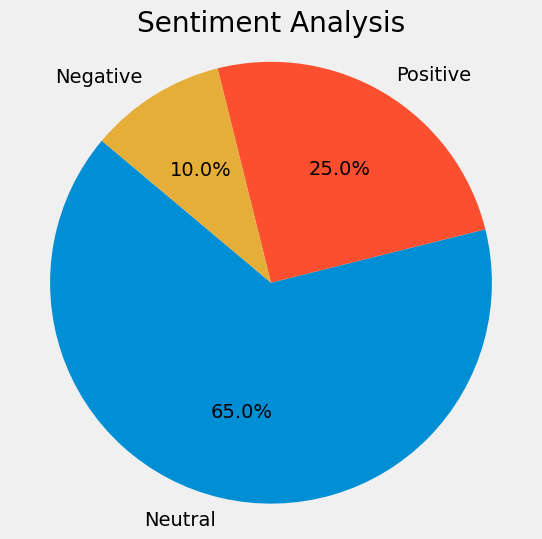

In [ ]:
#creating Pie Chart
# Count the number of each sentiment category
sentiment_counts = comments_df["Sentiment"].value_counts()

# Create a pie chart
plt.figure(figsize=(6, 6))
plt.pie(sentiment_counts, labels=sentiment_counts.index, autopct='%1.1f%%', startangle=140)
plt.title("Sentiment Analysis")
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
# Save the pie chart as an image
plt.savefig('pie_chart.png')

# Display the pie chart
plt.show()

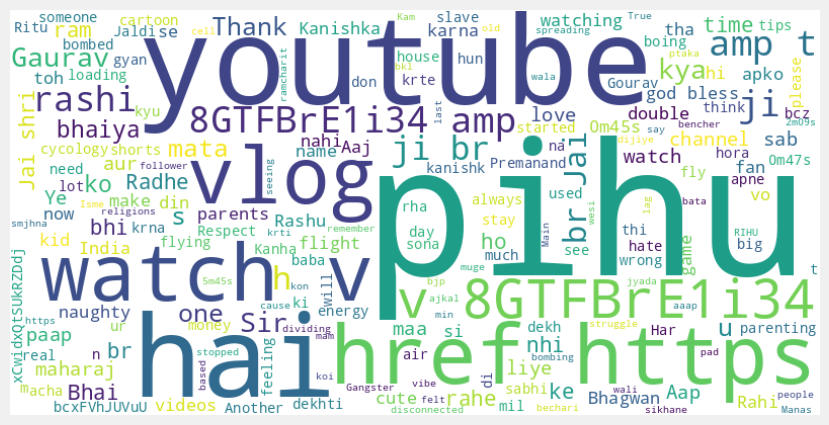

In [ ]:
#wordcloud
# Concatenate all comments into a single text
comments_text = " ".join(comments_df["Comment Text"])

# Create a WordCloud object
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(comments_text)

# Display the WordCloud
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()
# Save the word cloud as an image
wordcloud.to_file('wordcloud.png')

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import linear_kernel
import pandas as pd

pd.set_option('display.max_colwidth', None)

# Extract video titles and comment texts
video_ids = [item["id"]["videoId"] for item in search_response.get("items", [])]
comment_texts = comments_df["Comment Text"].tolist()

# Create a TF-IDF vectorizer
tfidf_vectorizer = TfidfVectorizer()
tfidf_matrix = tfidf_vectorizer.fit_transform([video_ids[0]] + comment_texts)

# Compute cosine similarities
cosine_similarities = linear_kernel(tfidf_matrix, tfidf_matrix)

# Get video indices with high similarity (limit to 10 recommendations)
video_indices = cosine_similarities[0].argsort()[:-11:-1]

# Extract recommended video IDs
recommended_video_ids = [video_ids[i] for i in video_indices[1:]]

# Fetch recommended video titles from video IDs
recommended_video_titles = []

for video_id in recommended_video_ids:
    request = youtube.videos().list(
        part="snippet",
        id=video_id
    )
    response = request.execute()

    if "items" in response:
        video_item = response["items"][0]
        video_title = video_item["snippet"]["title"]
        recommended_video_titles.append(video_title)

# Create a DataFrame for recommended video titles
recommended_titles_df = pd.DataFrame(recommended_video_titles, columns=["Recommended Videos"])
print(recommended_titles_df)

                                 Recommended Videos
0  Inside Dubai's Rich Private Jets | DUBAI AIRSHOW
1                    Pihu trying hard to copy Rashi
2                             The Thugesh Show VLOG
3                        Relationships are TOUGH !!
4   Desh Ka Dhoni | Episode 02 | Social Media विवाद
5               School Na Jaane ke naye naye Bahane
6               Desh Ka Dhoni | Episode 03 | संघर्ष
7                            Papa ko Ullu Banaya !!
8             Desh Ka Dhoni | Episode 05 | इंसानियत


In [ ]:
doc = Document()

# Add a title to the document
doc.add_heading('YouTube Analysis Report', 0)

# Add comments to the document
doc.add_heading('Comments', level=1)

for comment in comment_texts:
    doc.add_paragraph(comment)

# Add the pie chart to the document
doc.add_heading('Sentiment Pie Chart', level=1)

# Add the pie chart image to the Word document
doc.add_picture('pie_chart.png', width=Inches(4.0))

# Add the word cloud image to the Word document
doc.add_picture('wordcloud.png', width=Inches(4.0))

# Add recommendations to the document
doc.add_heading('Recommendations', level=1)

for recommendation in recommended_video_titles:
    doc.add_paragraph(recommendation)

# Save the Word document
doc.save('youtube_analysis_report.docx')

In [ ]:
# Get the current working directory
current_directory = os.getcwd()

# List the files in the current directory
file_list = os.listdir(current_directory)

# Print the list of files
print("Files in the current directory:")
for file in file_list:
    print(file)



Files in the current directory:
.config
youtube_analysis_report.docx
wordcloud.png
pie_chart.png
sample_data


In [ ]:
from google.colab import files

# Specify the file you want to download
file_to_download = "youtube_analysis_report.docx"  # Replace with your actual filename

# Use the files module to download the file
files.download(file_to_download)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>